In [129]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.1 MB 12 kB/s  eta 0:00:015   |▌                               | 12.3 MB 6.9 MB/s eta 0:01:51     |▋                               | 14.1 MB 6.9 MB/s eta 0:01:51     |▊                               | 18.3 MB 8.0 MB/s eta 0:01:35     |█                               | 24.6 MB 5.9 MB/s eta 0:02:08     |█                               | 26.5 MB 5.9 MB/s eta 0:02:08     |█▍                              | 34.8 MB 9.0 MB/s eta 0:01:23     |█▌                              | 37.2 MB 9.0 MB/s eta 0:01:22     |█▋                              | 38.6 MB 9.6 MB/s eta 0:01:17     |██▉                             | 68.8 MB 6.7 MB/s eta 0:01:47     |███                             | 71.3 MB 6.7 MB/s eta 0:01:46     |███▎                            | 79.4 MB 6.3 MB/s eta 0:01:52     |███▉                            | 92.3 MB 10.5 MB/s eta 0:01:06     |████                            | 96.8 MB 10.5 MB/s eta 0:01:05     |████▏                           | 100.0 

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [130]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import sklearn
import gensim

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [58]:
df_big_easy = pd.read_excel('Reviews.xlsx')
df_big_easy.head()

,author,reviewBody,reviewRating,ratingMaxvalue,reviewTags,dateCreated,images,reviewUrl,reviewSource,orginalText,name,reviewCount,aggregateRating,address,place_id,input,businessUrl
0,Jez Beadle,NaN,5.0,5.0,NaN,2 weeks ago,NaN,https://www.google.com/maps/contrib/1180472233...,www.google.com,NaN,Big Easy Canary Wharf,"3,511",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
1,Baemde 12,Toda la comida muy buena.....servicio pesimo,3.0,5.0,NaN,a week ago,NaN,https://www.google.com/maps/contrib/1140921831...,www.google.com,NaN,Big Easy Canary Wharf,"3,511",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
2,Will Bruce,NaN,5.0,5.0,NaN,6 days ago,NaN,https://www.google.com/maps/contrib/1071015506...,www.google.com,NaN,Big Easy Canary Wharf,"3,511",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
3,Kat Reyes,Food was lovely but service was bad. We waited...,3.0,5.0,NaN,6 days ago,NaN,https://www.google.com/maps/contrib/1141925582...,www.google.com,NaN,Big Easy Canary Wharf,"3,511",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
4,Gobi Sittampalam,Very tasty seafood platter.. Drinks were decen...,5.0,5.0,NaN,a week ago,NaN,https://www.google.com/maps/contrib/1082484853...,www.google.com,NaN,Big Easy Canary Wharf,"3,511",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...


In [16]:
df_big_easy.shape

(100, 17)

### Keep interesting columns, remove rows with review missing

In [113]:
df_big_easy_clean = df_big_easy[['reviewBody', 'reviewRating', 'dateCreated']].copy(deep=True)
df_big_easy_clean = df_big_easy_clean.dropna(subset=['reviewBody'])
print(df_big_easy_clean.shape)
df_big_easy_clean.head()

(69, 3)


,reviewBody,reviewRating,dateCreated
1,Toda la comida muy buena.....servicio pesimo,3.0,a week ago
3,Food was lovely but service was bad. We waited...,3.0,6 days ago
4,Very tasty seafood platter.. Drinks were decen...,5.0,a week ago
6,I really would not recommend this restaurant. ...,2.0,a month ago
9,"Was there for my wife's bday, the ambience was...",5.0,3 weeks ago


### Date cleaning

Turn '1 week ago', '6 hours ago' etc. into dates

In [120]:
# Turn strings into dates
def clean_date(string_date):
    curr_date = datetime.now()
    split_date = string_date.split(' ')

    n = split_date[0]
    n = 1 if n=='a' else int(n) # Replace 'a week ago' with '1 week ago'
    
    delta = split_date[1]
    
    # Check assumption that any n>1 must be plural
    assert (n==1) or (n>1 and delta[-1]=='s')
    
    # Stip trailing 's' from delta
    if n>1:
        delta = delta[:-1]

    if delta == 'year':
        return curr_date - timedelta(days=365*n)
    elif delta == 'month':
        return curr_date - timedelta(days=30*n)
    elif delta == 'week':
        return curr_date - timedelta(weeks=n)
    elif delta == 'day':
        return curr_date - timedelta(days=n)
    elif delta == 'hour':
        return curr_date - timedelta(hours=n)
    elif delta == 'minute':
        return curr_date - timedelta(minutes=n)
    elif delta == 'moment':
        return curr_date - timedelta(seconds=n)
    else:
        raise ValueError(f'Unhandled delta type {delta}')

In [123]:
df_big_easy_clean['date_clean'] = df_big_easy_clean['dateCreated'].apply(lambda d: clean_date(d)).astype('datetime64[D]')
df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,review_lower_alpha,date_clean
1,Toda la comida muy buena.....servicio pesimo,3.0,a week ago,toda la comida muy buenaservicio pesimo,2021-07-21
3,Food was lovely but service was bad. We waited...,3.0,6 days ago,food was lovely but service was bad we waited ...,2021-07-22
4,Very tasty seafood platter.. Drinks were decen...,5.0,a week ago,very tasty seafood platter drinks were decent ...,2021-07-21
6,I really would not recommend this restaurant. ...,2.0,a month ago,i really would not recommend this restaurant w...,2021-06-28
9,"Was there for my wife's bday, the ambience was...",5.0,3 weeks ago,was there for my wifes bday the ambience was n...,2021-07-07


### Language cleaning

Only keep English reviews (run the below if you need to download corpus).

In [114]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

Start by cleaning text

In [115]:
def clean_text(text):
    
    tokens = text.split(' ')
    tokens_lower = [t.lower() for t in tokens]
    tokens_alpha = [re.sub('[^A-z]', '', t) for t in tokens_lower]
    text_clean = ' '.join(tokens_alpha)
    
    return text_clean
    

df_big_easy_clean['review_lower_alpha'] = df_big_easy_clean.apply(lambda row: clean_text(row['reviewBody']),
                                                                  axis=1)

df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,review_lower_alpha
1,Toda la comida muy buena.....servicio pesimo,3.0,a week ago,toda la comida muy buenaservicio pesimo
3,Food was lovely but service was bad. We waited...,3.0,6 days ago,food was lovely but service was bad we waited ...
4,Very tasty seafood platter.. Drinks were decen...,5.0,a week ago,very tasty seafood platter drinks were decent ...
6,I really would not recommend this restaurant. ...,2.0,a month ago,i really would not recommend this restaurant w...
9,"Was there for my wife's bday, the ambience was...",5.0,3 weeks ago,was there for my wifes bday the ambience was n...


Then check how many words are in English corpus.

In [116]:
eng_words = words.words('en')
eng_words_lower = [w.lower() for w in eng_words]

In [117]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
sw = stopwords.words('english')

In [118]:
df_big_easy_eng = df_big_easy_clean.copy(deep=True)

# Assume any review where > 50% of first 10 words are in English corpus, is an English review
def pct_review_words_in_eng_corpus(text):
    
    tokens = text.split(' ')[:10]
    n_tokens = len(tokens)
    tokens_in_eng_corpus = np.sum([1 if t in eng_words_lower else 0 for t in tokens])
    
    return float(tokens_in_eng_corpus)/n_tokens


df_big_easy_eng['is_english'] = df_big_easy_eng.apply(lambda row: pct_review_words_in_eng_corpus(row['review_lower_alpha']) >= 0.5,
                                                      axis=1)

# Drop rows
df_big_easy_eng = df_big_easy_eng[df_big_easy_eng['is_english']==True].drop(['is_english'], axis=1)

# Then remove stopwords
def remove_stopwords(text):
    
    tokens = text.split(' ')
    tokens_no_sw = [t for t in tokens if t not in sw]
    
    return ' '.join(tokens_no_sw)

df_big_easy_eng['review_clean'] = df_big_easy_eng['review_lower_alpha'].apply(lambda t: remove_stopwords(t))
df_big_easy_eng = df_big_easy_eng.drop('review_lower_alpha', axis=1)

df_big_easy_eng.head()

,reviewBody,reviewRating,dateCreated,review_clean
3,Food was lovely but service was bad. We waited...,3.0,6 days ago,food lovely service bad waited ages one really...
4,Very tasty seafood platter.. Drinks were decen...,5.0,a week ago,tasty seafood platter drinks decent well great...
6,I really would not recommend this restaurant. ...,2.0,a month ago,really would recommend restaurant fussy eaters...
9,"Was there for my wife's bday, the ambience was...",5.0,3 weeks ago,wifes bday ambience nice luckily got seat wind...
12,"today in your service I got a cold dish, someo...",1.0,3 weeks ago,today service got cold dish someone mistook sa...


### Analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

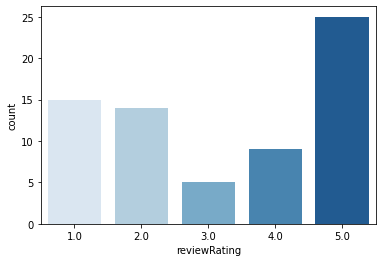

In [102]:
sns.countplot(data=df_big_easy_eng,
              x='reviewRating',
              palette='Blues')

Reviews appear to be fairly polarised, with 1/2/5 starts being the most common - and little inbetween

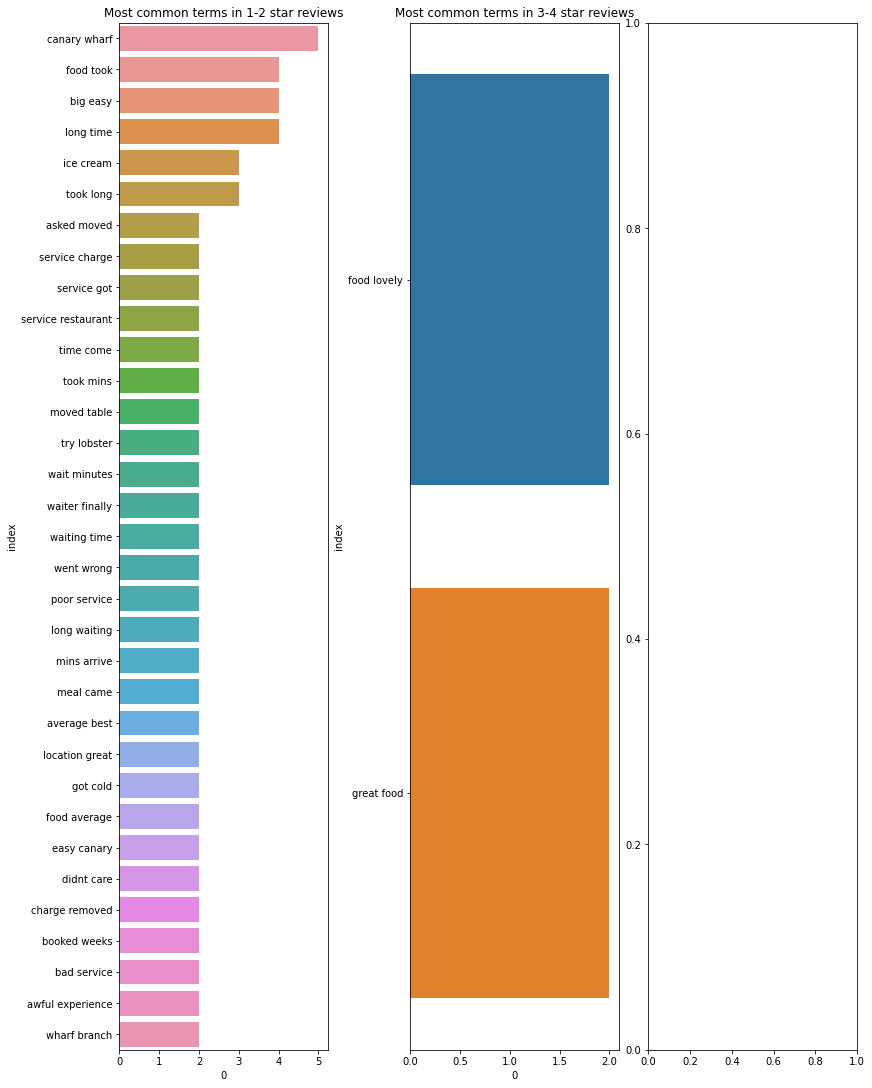

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(2):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_eng.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(2,2),
                        max_df=1.0,
                        min_df=2,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')